In [7]:
#%matplotlib inline
import os
import sys
AbsPath = os.path.abspath("")
sys.path.append(AbsPath+"/../..")
import pickle
import numpy as np
import pandas as pd
import scipy
import importlib
from numba import jit
from scipy.interpolate import interp1d as int1d
from scipy import interpolate
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
from colossus.lss import mass_function
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
from Functions import Functions as F
cosmology.setCosmology("millennium")
Cosmo = cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1
h = Cosmo.h
h_3 = h*h*h
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)


#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}

AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}

#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20

plt.rcParams['font.size']=15

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [8]:
importlib.reload(F)

<module 'Functions.Functions' from '/data/pg1g15/STEEL/Notebooks/Tests/../../Functions/Functions.py'>

# Load a VDB average halomassfile

In [9]:
#AvaHaloMass_wz = np.loadtxt("./MasterArr/11.016.60.050.6774.dat")
#AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.10.6774.dat")
AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.10.73.dat")
#AvaHaloMass_wz = np.loadtxt(AbsPath+"/../../Data/Model/Input/11.016.60.050.73.dat")

z = AvaHaloMass_wz[:,0]
AvaHaloMass = AvaHaloMass_wz[:,1:]
z_Cut_Bin = np.digitize(0.1, bins = z)
z, AvaHaloMass = z[z_Cut_Bin:], AvaHaloMass[z_Cut_Bin:]
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
SatHaloBin = 0.1
SatHaloMass = np.arange(np.min(AvaHaloMass[0])-1, np.max(AvaHaloMass[0])-0.1 + np.log10(h), SatHaloBin) 

# Accelerated Functions

In [10]:
@jit#('double[:,:],double[:,:],double[:,:](double[:,:,:],double[:,:,:], double[:],double[:])')
def JitLoop(SHMF_Entering, Mass_Ratio_Bins, z_step, t_step):
    m, n, o = np.shape(SHMF_Entering)
    Accreted_Above_Ratio = np.zeros((m, n))
    Accreted_Above_Ratio_dz = np.zeros((m, n))
    Accreted_Above_Ratio_dt = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            Accreted_Above_Ratio[i,j] = np.sum(SHMF_Entering[i, j,Mass_Ratio_Bins[i,j]:])*SatHaloBin
            Accreted_Above_Ratio_dz[i,j] = np.sum(SHMF_Entering[i, j,Mass_Ratio_Bins[i,j]:])*SatHaloBin/z_step[i]
            Accreted_Above_Ratio_dt[i,j] = np.sum(SHMF_Entering[i, j,Mass_Ratio_Bins[i,j]:])*SatHaloBin/t_step[i]
    return Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt

@jit#('double[:,:],double[:,:],double[:,:](double[:,:,:],double[:,:,:],double[:],double[:], double[:])')
def JitLoop2(SHMF_Entering, Mass_Ratio_Bins, SatHaloMass, z_step, t_step):
    m, n, o = np.shape(SHMF_Entering)
    Accreted_Above_Ratio = np.zeros((m, n))
    Accreted_Above_Ratio_dz = np.zeros((m, n))
    Accreted_Above_Ratio_dt = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            Accreted_Above_Ratio[i,j] = np.sum(SHMF_Entering[i,j,Mass_Ratio_Bins[i,j]:]*SatHaloMass[Mass_Ratio_Bins[i,j]:])*SatHaloBin
            Accreted_Above_Ratio_dz[i,j] = np.sum(SHMF_Entering[i,j,Mass_Ratio_Bins[i,j]:]*SatHaloMass[Mass_Ratio_Bins[i,j]:])*SatHaloBin/z_step[i]
            Accreted_Above_Ratio_dt[i,j] = np.sum(SHMF_Entering[i,j,Mass_Ratio_Bins[i,j]:]*SatHaloMass[Mass_Ratio_Bins[i,j]:])*SatHaloBin/t_step[i]
    return Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt

# This Version Has the central number density integral to the SHMFs

In [ ]:
#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}
a, b = np.shape(AvaHaloMass)
c = np.size(SatHaloMass)
print(a,b,c)
#Make  m_M to FOR uSHMF from Jing et al
m_M = np.array([[SatHaloMass - AvaHaloMass[i][j] for j in range(b)] for i in range(a)])
#Create SHMF arrays (no redshift evolution)
SHMFs = np.array([[F.dn_dlnX(Unevolved, np.power(10, m_M[i][j]))*\
                   mass_function.massFunction(np.power(10,AvaHaloMass[i,j]), z[i], mdef = 'vir', model = 'despali16', q_out='dndlnM')*np.log(10)*AvaHaloMassBins[i,j]\
                   for j in range(b)] for i in range(a)])
#Calculate the number density of halos that fall in at each timestep
SHMF_Entering = np.array([[SHMFs[:, i][j] - SHMFs[:, i][j+1] for i in range(b)] for j in range(a-1)])

print(np.shape(SHMF_Entering))
print(np.shape(z))
z_step = z[1:] - z[:-1]
t_step = Cosmo.age(z[:-1]) - Cosmo.age(z[1:])
print(np.shape(z_step))
print(np.shape(SatHaloMass))
print(np.shape(AvaHaloMass))
Mass_Ratio_Limit = AvaHaloMass + np.log10(0.3)
print(np.shape(Mass_Ratio_Limit))
Mass_Ratio_Bins = np.digitize(Mass_Ratio_Limit, bins = SatHaloMass)[:-1]
print(np.shape(Mass_Ratio_Bins))
Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt =  JitLoop(SHMF_Entering, Mass_Ratio_Bins, z_step, t_step)
print(np.shape(Accreted_Above_Ratio))

M0 = 13
M0_Bin = np.digitize(M0, bins = AvaHaloMass[0])


f, SubPlots = plt.subplots(1, 2, figsize = (12,4), sharey = 'row')


z_bins = [180, 131, 130, 30, 25]

MaxCat = np.array([])
for i in z_bins:
    SubPlots[0].plot(SatHaloMass, np.log10(SHMFs[i, M0_Bin]))
    SubPlots[1].plot(SatHaloMass- AvaHaloMass[i, M0_Bin], np.log10(SHMF_Entering[i, M0_Bin]), label = (round(AvaHaloMass[i, M0_Bin],2),round(z[i],2)))
    SubPlots[0].vlines(SatHaloMass[Mass_Ratio_Bins[i, M0_Bin]],-10, np.log10(SHMFs[i, M0_Bin, Mass_Ratio_Bins[i, M0_Bin]]))
    SubPlots[1].vlines(SatHaloMass[Mass_Ratio_Bins[i, M0_Bin]]- AvaHaloMass[i, M0_Bin], -10, np.log10(SHMF_Entering[i, M0_Bin, Mass_Ratio_Bins[i, M0_Bin]]))
    MaxCat = np.concatenate((MaxCat, np.log10(SHMFs[i, M0_Bin])))

ylim = np.max(MaxCat)
if ylim > 0.9: ylim = 0.9
SubPlots[1].set_ylim(ylim-6, ylim+0.1)
SubPlots[1].vlines(np.log10(0.3), ylim-6, ylim+0.1, color = "r")

SubPlots[0].set_title("SHMF for halo mass M0 = {} at (M, z)".format(round(AvaHaloMass[0, M0_Bin],2)))
SubPlots[1].set_title("Accreted SHMF for halo mass M0 = {} at (M, z)".format(round(AvaHaloMass[0, M0_Bin],2)))
SubPlots[0].set_xlabel("Mh")
SubPlots[1].set_xlabel("Mh")
SubPlots[0].set_ylabel("log10 N mpc^-3 h^3 dex^-1")
SubPlots[1].set_ylabel("log10 deltaN mpc^-3 h^3 dex^-1")
SubPlots[1].legend()
plt.show()


Mass_Ratio_Limit = AvaHaloMass + np.log10(0.001)
Mass_Ratio_Bins = np.digitize(Mass_Ratio_Limit, bins = SatHaloMass)[1:]
MassAccretion, MassAccretion_dz, MassAccretion_dt =  JitLoop2(SHMF_Entering, Mass_Ratio_Bins, np.power(10,SatHaloMass), z_step, t_step)


MassTrackND = mass_function.massFunction(np.power(10, AvaHaloMass[:,M0_Bin]), z, mdef = 'vir', model = 'despali16', q_out='dndlnM')*np.log(10)*AvaHaloMassBins[:,M0_Bin]
plt.plot(z, np.log10(MassTrackND))
plt.title("Mass track abundance against redshift")
plt.xlabel("z")
plt.ylabel("log10 N mpc^-3 h^3 dex^-1")
plt.show()


plt.plot(z, AvaHaloMass[:,M0_Bin], label = "M")
plt.title("Masstrack growth against redshift")
plt.xlabel("z")
plt.ylabel("Mh")
plt.legend()
plt.show()


dm = np.log10((np.power(10,AvaHaloMass[:-1,M0_Bin]) - np.power(10,AvaHaloMass[1:,M0_Bin]))*MassTrackND[:-1])
dm_dz = np.log10((np.power(10,AvaHaloMass[:-1,M0_Bin]) - np.power(10,AvaHaloMass[1:,M0_Bin]))*MassTrackND[:-1]) -np.log10(z_step)
dm_dt = np.log10((np.power(10,AvaHaloMass[:-1,M0_Bin]) - np.power(10,AvaHaloMass[1:,M0_Bin]))*MassTrackND[:-1]) -np.log10(t_step)


plt.plot(z[:-1],  dm_dz, label = "dMh/dz")
plt.plot(z[:-1], np.log10(MassAccretion_dz[:,M0_Bin]), label = "dMacc/dz")
plt.title("dM and dMacc against redshift")
plt.legend()
plt.show()


f, SubPlots = plt.subplots(1, 3, figsize = (18,4), sharex = True)

SubPlots[0].semilogy(z[:-1], Accreted_Above_Ratio[:,M0_Bin]/MassTrackND[:-1])
SubPlots[1].semilogy(z[:-1], Accreted_Above_Ratio_dz[:,M0_Bin]/MassTrackND[:-1])
SubPlots[2].semilogy(z[:-1], Accreted_Above_Ratio_dt[:,M0_Bin]/MassTrackND[:-1])


SubPlots[0].set_xlabel("z")
SubPlots[1].set_xlabel("z")
SubPlots[2].set_xlabel("z")
SubPlots[0].set_ylabel("dNdsimstep")
SubPlots[1].set_ylabel("dNdz")
SubPlots[2].set_ylabel("dNdt")
SubPlots[1].set_title("Merger Rate (dz, dt) along masstrack against redshift")
#plt.ylim(0.1, 1)
plt.tight_layout()
plt.show()

f, SubPlots = plt.subplots(1, 3, figsize = (18,4))#, sharey = True, sharex = True)
for j, M0 in enumerate([11, 12, 13, 14]):
    Y = []
    Y_dz = []
    Y_dt = []
    X = []
    for i in range(len(z[:-1])):
        try:
            M0_bin_zi = np.digitize(M0, bins = AvaHaloMass[i]) -1
            #print(i, M0_bin_zi)
            Y.append(Accreted_Above_Ratio[i,M0_bin_zi]\
                    /(mass_function.massFunction(np.power(10,AvaHaloMass[i,M0_bin_zi]), z[i], mdef = 'vir', model = 'despali16', q_out='dndlnM')*np.log(10)*AvaHaloMassBins[i,M0_bin_zi]))
            Y_dz.append(Accreted_Above_Ratio_dz[i,M0_bin_zi]\
                    /(mass_function.massFunction(np.power(10,AvaHaloMass[i,M0_bin_zi]), z[i], mdef = 'vir', model = 'despali16', q_out='dndlnM')*np.log(10)*AvaHaloMassBins[i,M0_bin_zi]))
            Y_dt.append(Accreted_Above_Ratio_dt[i,M0_bin_zi]\
                    /(mass_function.massFunction(np.power(10,AvaHaloMass[i,M0_bin_zi]), z[i], mdef = 'vir', model = 'despali16', q_out='dndlnM')*np.log(10)*AvaHaloMassBins[i,M0_bin_zi]))
            X.append(z[i])
        except:
            break
    SubPlots[0].semilogy(X, Y, label = M0)
    SubPlots[1].semilogy(X, Y_dz, label = M0)
    SubPlots[2].semilogy(X, Y_dt, label = M0)
SubPlots[1].set_title("Merger Rate at fixed M against redshift")
SubPlots[1].set_ylim(0.1, 1)
SubPlots[2].set_ylim(0.01, 10)
SubPlots[0].set_xlabel("z")
SubPlots[1].set_xlabel("z")
SubPlots[2].set_xlabel("z")
SubPlots[0].set_ylabel("dNdsimstep")
SubPlots[1].set_ylabel("dNdz")
SubPlots[2].set_ylabel("dNdt")
SubPlots[2].legend()
plt.tight_layout()
plt.show()

# This version acts like STEEL (Paper1) where the SHMFs are central ND agnostic

In [21]:
VDB_otp = F.Halogrowth(12.2, FullReturn = True)

In [22]:
np.shape(VDB_otp)

(200, 8)

190 57 63
(189, 57, 63)
(190,)
(189,)
(63,)
(190, 57)
(190, 57)
(189, 57)
(189, 57)


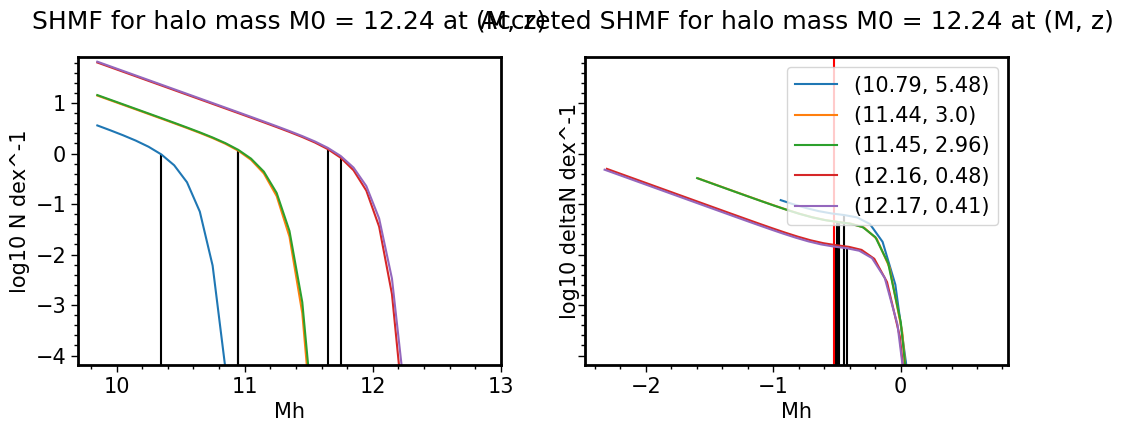

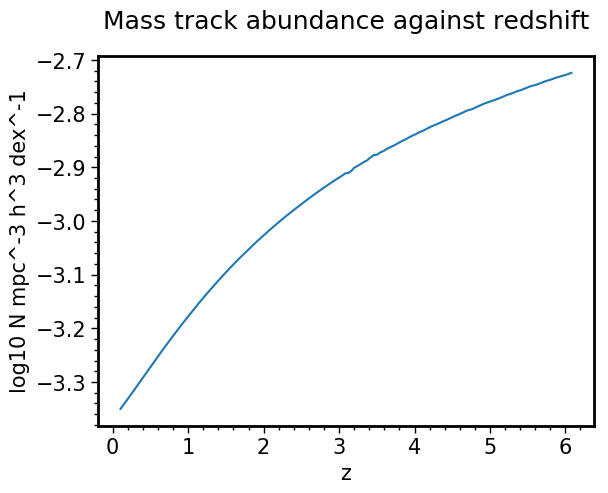

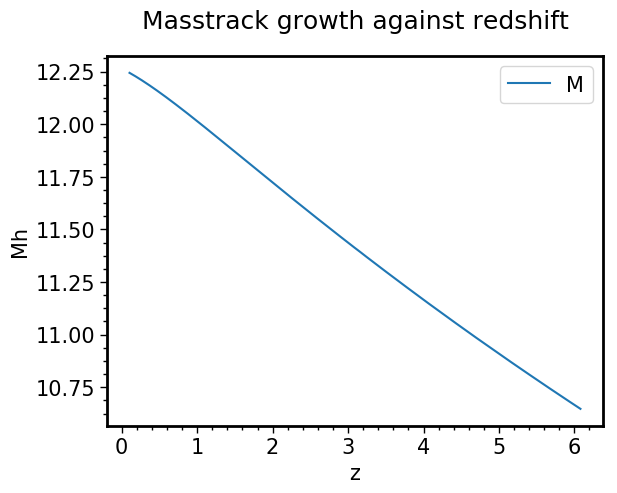

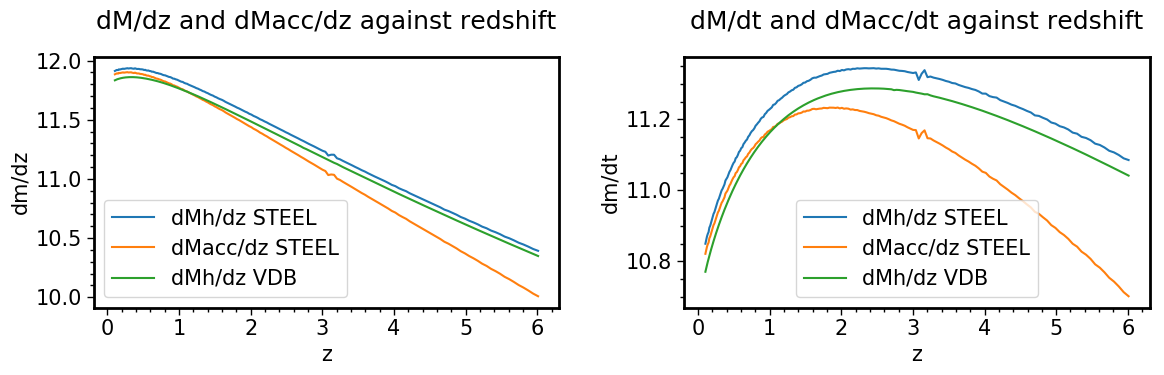

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

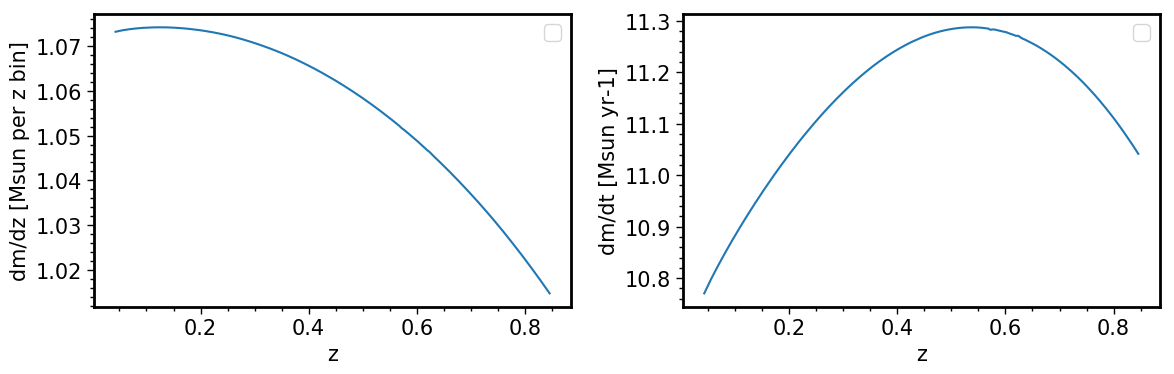

<Figure size 640x480 with 0 Axes>

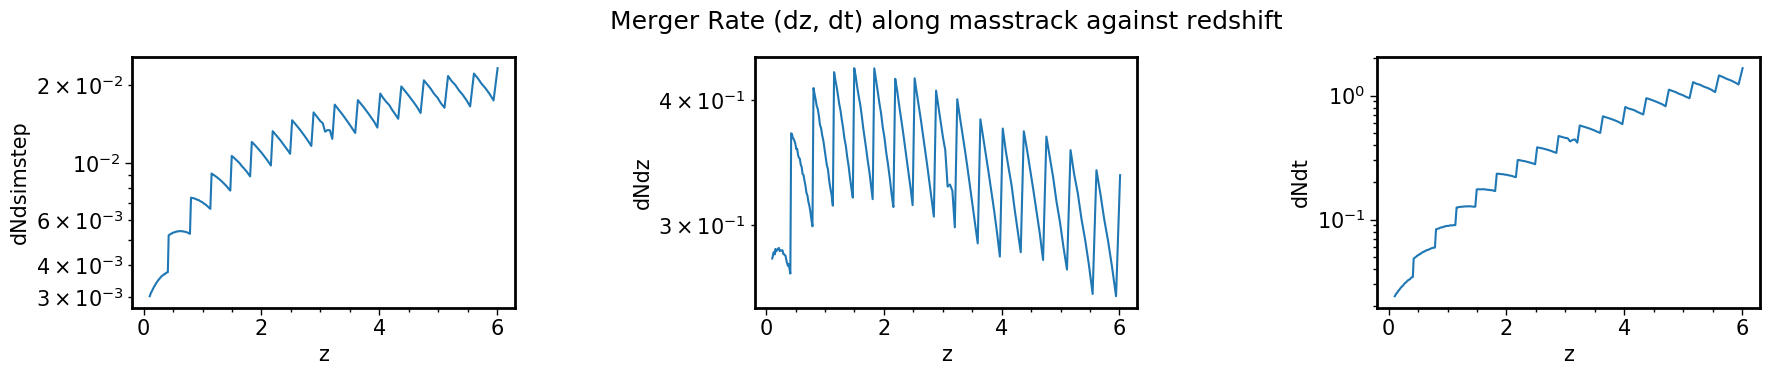

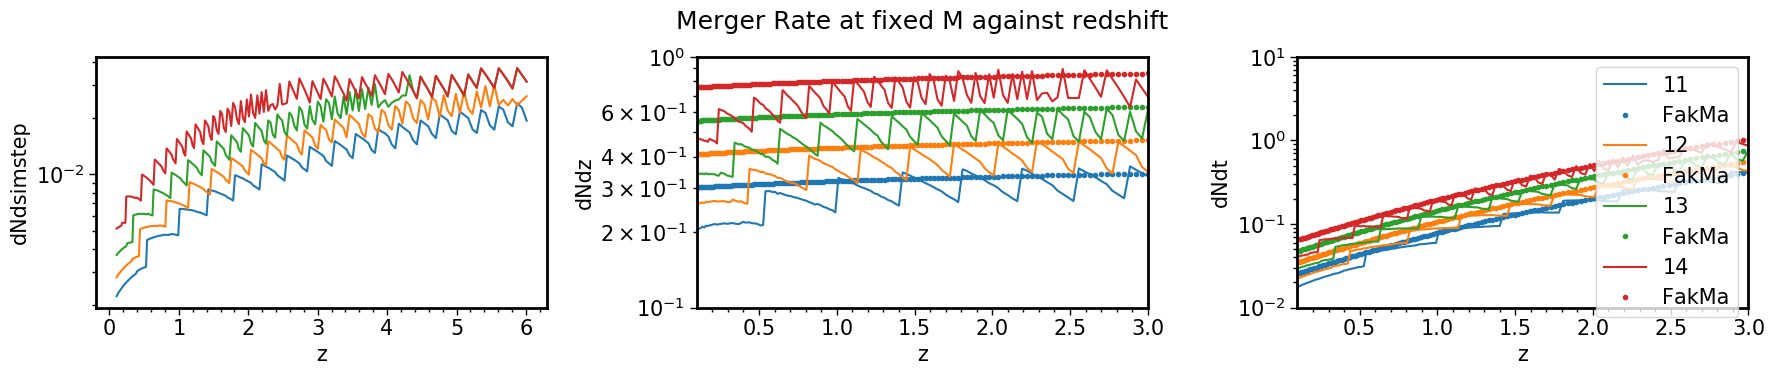

In [25]:
#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}
a, b = np.shape(AvaHaloMass)
c = np.size(SatHaloMass)
print(a,b,c)
#Make  m_M to FOR uSHMF from Jing et al
m_M = np.array([[SatHaloMass - AvaHaloMass[i][j] for j in range(b)] for i in range(a)])
#Create SHMF arrays (no redshift evolution)
SHMFs = np.array([[F.dn_dlnX(Unevolved, np.power(10, m_M[i][j]))\
                   for j in range(b)] for i in range(a)])
#Calculate the number density of halos that fall in at each timestep
SHMF_Entering = np.array([[SHMFs[:, i][j] - SHMFs[:, i][j+1] for i in range(b)] for j in range(a-1)])

print(np.shape(SHMF_Entering))
print(np.shape(z))
z_step = z[1:] - z[:-1]
t_step = Cosmo.age(z[:-1]) - Cosmo.age(z[1:])
print(np.shape(z_step))
print(np.shape(SatHaloMass))
print(np.shape(AvaHaloMass))
Mass_Ratio_Limit = AvaHaloMass + np.log10(0.3)
print(np.shape(Mass_Ratio_Limit))
Mass_Ratio_Bins = np.digitize(Mass_Ratio_Limit, bins = SatHaloMass)[:-1]
print(np.shape(Mass_Ratio_Bins))
Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt =  JitLoop(SHMF_Entering, Mass_Ratio_Bins, z_step, t_step)
print(np.shape(Accreted_Above_Ratio))

M0 = 12.2
M0_Bin = np.digitize(M0, bins = AvaHaloMass[0])


f, SubPlots = plt.subplots(1, 2, figsize = (12,4), sharey = 'row')


z_bins = [180, 131, 130, 30, 25]

MaxCat = np.array([])
for i in z_bins:
    SubPlots[0].plot(SatHaloMass, np.log10(SHMFs[i, M0_Bin]))
    SubPlots[1].plot(SatHaloMass- AvaHaloMass[i, M0_Bin], np.log10(SHMF_Entering[i, M0_Bin]), label = (round(AvaHaloMass[i, M0_Bin],2),round(z[i],2)))
    SubPlots[0].vlines(SatHaloMass[Mass_Ratio_Bins[i, M0_Bin]],-10, np.log10(SHMFs[i, M0_Bin, Mass_Ratio_Bins[i, M0_Bin]]))
    SubPlots[1].vlines(SatHaloMass[Mass_Ratio_Bins[i, M0_Bin]]- AvaHaloMass[i, M0_Bin], -10, np.log10(SHMF_Entering[i, M0_Bin, Mass_Ratio_Bins[i, M0_Bin]]))
    MaxCat = np.concatenate((MaxCat, np.log10(SHMFs[i, M0_Bin])))

ylim = np.max(MaxCat)
if ylim > 1.9: ylim = 1.9
SubPlots[1].set_ylim(ylim-6, ylim+0.1)
SubPlots[1].vlines(np.log10(0.3), ylim-6, ylim+0.1, color = "r")

SubPlots[0].set_title("SHMF for halo mass M0 = {} at (M, z)".format(round(AvaHaloMass[0, M0_Bin],2)))
SubPlots[1].set_title("Accreted SHMF for halo mass M0 = {} at (M, z)".format(round(AvaHaloMass[0, M0_Bin],2)))
SubPlots[0].set_xlabel("Mh")
SubPlots[1].set_xlabel("Mh")
SubPlots[0].set_ylabel("log10 N dex^-1")
SubPlots[1].set_ylabel("log10 deltaN dex^-1")
SubPlots[1].legend()
plt.show()


Mass_Ratio_Limit = AvaHaloMass + np.log10(0.001)
Mass_Ratio_Bins = np.digitize(Mass_Ratio_Limit, bins = SatHaloMass)[1:]
MassAccretion, MassAccretion_dz, MassAccretion_dt =  JitLoop2(SHMF_Entering, Mass_Ratio_Bins, np.power(10,SatHaloMass), z_step, t_step)


MassTrackND = mass_function.massFunction(np.power(10, AvaHaloMass[:,M0_Bin]), z, mdef = 'vir', model = 'despali16', q_out='dndlnM')*np.log(10)*AvaHaloMassBins[:,M0_Bin]
plt.plot(z, np.log10(MassTrackND))
plt.title("Mass track abundance against redshift")
plt.xlabel("z")
plt.ylabel("log10 N mpc^-3 h^3 dex^-1")
plt.show()


plt.plot(z, AvaHaloMass[:,M0_Bin], label = "M")
plt.title("Masstrack growth against redshift")
plt.xlabel("z")
plt.ylabel("Mh")
plt.legend()
plt.show()


dm = np.log10((np.power(10,AvaHaloMass[:-1,M0_Bin]) - np.power(10,AvaHaloMass[1:,M0_Bin])))
dm_dz = np.log10((np.power(10,AvaHaloMass[:-1,M0_Bin]) - np.power(10,AvaHaloMass[1:,M0_Bin]))) -np.log10(z_step)
dm_dt = np.log10((np.power(10,AvaHaloMass[:-1,M0_Bin]) - np.power(10,AvaHaloMass[1:,M0_Bin]))) -np.log10(t_step)

f, SubPlots = plt.subplots(1, 2, figsize = (12,4), sharex = True)

SubPlots[0].plot(z[:-1],  dm_dz, label = "dMh/dz STEEL")
SubPlots[0].plot(z[:-1], np.log10(MassAccretion_dz[:,M0_Bin]), label = "dMacc/dz STEEL")
SubPlots[0].plot(VDB_otp[z_Cut_Bin:-1,1],  np.log10((VDB_otp[z_Cut_Bin:-1:,7]*(10**9))*(t_step/z_step)), label = "dMh/dz VDB")
SubPlots[0].set_ylabel("dm/dz")
SubPlots[0].set_xlabel("z")
SubPlots[0].set_title("dM/dz and dMacc/dz against redshift")
SubPlots[0].legend()

SubPlots[1].plot(z[:-1],  dm_dt, label = "dMh/dz STEEL")
SubPlots[1].plot(z[:-1], np.log10(MassAccretion_dt[:,M0_Bin]), label = "dMacc/dz STEEL")
SubPlots[1].plot(VDB_otp[z_Cut_Bin:-1,1],  np.log10((VDB_otp[z_Cut_Bin:-1:,7]*(10**9))), label = "dMh/dz VDB")
SubPlots[1].set_ylabel("dm/dt")
SubPlots[1].set_xlabel("z")
SubPlots[1].set_title("dM/dt and dMacc/dt against redshift")
SubPlots[1].legend()

plt.tight_layout()
plt.show()
plt.clf()


f, SubPlots = plt.subplots(1, 2, figsize = (12,4), sharex = True)

SubPlots[0].plot(np.log10(VDB_otp[z_Cut_Bin:-1,1]  + 1),  np.log10(np.log10((VDB_otp[z_Cut_Bin:-1:,7]*(10**9))*(t_step/z_step))) )
SubPlots[0].set_ylabel("dm/dz [Msun per z bin]")
SubPlots[0].set_xlabel("z")
SubPlots[0].legend()

SubPlots[1].plot(np.log10(VDB_otp[z_Cut_Bin:-1,1]  + 1),  np.log10((VDB_otp[z_Cut_Bin:-1:,7]*(10**9))) )
SubPlots[1].set_ylabel("dm/dt [Msun yr-1]")
SubPlots[1].set_xlabel("z")

SubPlots[1].legend()
plt.tight_layout()
plt.show()
plt.clf()


f, SubPlots = plt.subplots(1, 3, figsize = (18,4), sharex = True)

SubPlots[0].semilogy(z[:-1], Accreted_Above_Ratio[:,M0_Bin])
SubPlots[1].semilogy(z[:-1], Accreted_Above_Ratio_dz[:,M0_Bin])
SubPlots[2].semilogy(z[:-1], Accreted_Above_Ratio_dt[:,M0_Bin])

SubPlots[0].set_xlabel("z")
SubPlots[1].set_xlabel("z")
SubPlots[2].set_xlabel("z")
SubPlots[0].set_ylabel("dNdsimstep")
SubPlots[1].set_ylabel("dNdz")
SubPlots[2].set_ylabel("dNdt")
SubPlots[1].set_title("Merger Rate (dz, dt) along masstrack against redshift")
#plt.ylim(0.1, 1)
plt.tight_layout()
plt.show()

def FakMa_MergerRate(M, z, e = 0.3):
    A = 0.0104; e_bar = 9.72*(10**-3);alpha = 0.133;beta=-1.995;gamma=0.263;nu=0.0993
    return A*np.power((M/10**12), alpha)*np.power(e, beta)*np.exp(np.power((e/e_bar),gamma))*np.power(1+z, nu)*e


f, SubPlots = plt.subplots(1, 3, figsize = (18,4))#, sharey = True, sharex = True)
colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "k"]
colourcycler = cycle(colours)
for j, M0 in enumerate([11, 12, 13, 14]):
    colour = next(colourcycler)
    Y = []
    Y_dz = []
    Y_dt = []
    X = []
    for i in range(len(z[:-1])):
        try:
            M0_bin_zi = np.digitize(M0, bins = AvaHaloMass[i]) -1
            #print(i, M0_bin_zi)
            Y.append(Accreted_Above_Ratio[i,M0_bin_zi])
            Y_dz.append(Accreted_Above_Ratio_dz[i,M0_bin_zi])
            Y_dt.append(Accreted_Above_Ratio_dt[i,M0_bin_zi])
            X.append(z[i])
        except:
            break
    SubPlots[0].semilogy(X, Y, label = M0, color = colour)
    SubPlots[1].semilogy(X, Y_dz, label = M0, color = colour) #STEEL
    SubPlots[1].semilogy(z, FakMa_MergerRate(10**M0, z), ".",label = "FakMa", color = colour) #FakMa
    SubPlots[2].semilogy(X, Y_dt, label = M0, color = colour)
    SubPlots[2].semilogy(z[1:], FakMa_MergerRate(10**M0, z[1:])*(z_step/t_step), ".",label = "FakMa", color = colour) #FakMa
SubPlots[1].set_title("Merger Rate at fixed M against redshift")
SubPlots[1].set_ylim(0.1, 1)
SubPlots[1].set_xlim(0.1, 3)
SubPlots[2].set_ylim(0.01, 10)
SubPlots[2].set_xlim(0.1, 3)
SubPlots[0].set_xlabel("z")
SubPlots[1].set_xlabel("z")
SubPlots[2].set_xlabel("z")
SubPlots[0].set_ylabel("dNdsimstep")
SubPlots[1].set_ylabel("dNdz")
SubPlots[2].set_ylabel("dNdt")
SubPlots[2].legend()
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


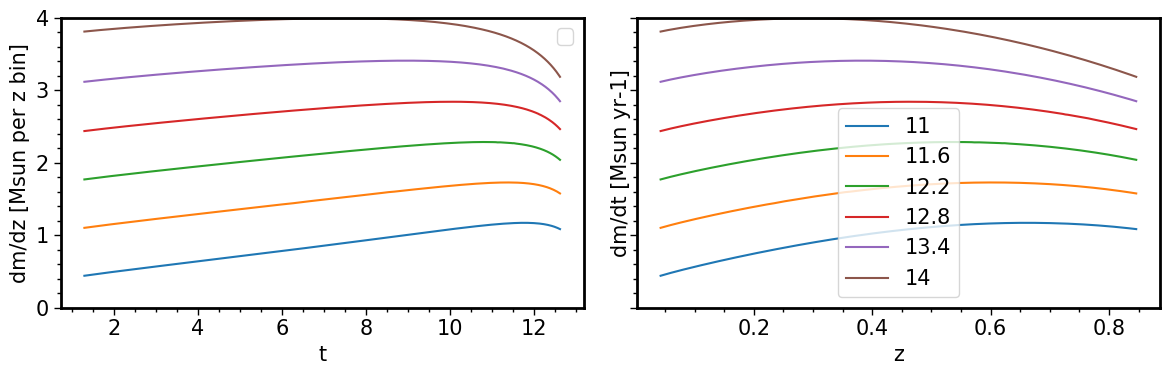

<Figure size 640x480 with 0 Axes>

In [38]:
f, SubPlots = plt.subplots(1, 2, figsize = (12,4), sharey = True)

for M in [11,11.6,12.2,12.8,13.4,14]:
    VDB_otp = F.Halogrowth(M, FullReturn = True)

    SubPlots[0].plot(VDB_otp[z_Cut_Bin:-1,2], np.log10(VDB_otp[z_Cut_Bin:-1:,7]))
    SubPlots[0].set_ylabel("dm/dz [Msun per z bin]")
    SubPlots[0].set_xlabel("t")

    SubPlots[1].plot(np.log10(VDB_otp[z_Cut_Bin:-1,1]  + 1),  np.log10(VDB_otp[z_Cut_Bin:-1:,7]), label = "{}".format(M))
    SubPlots[1].set_ylabel("dm/dt [Msun yr-1]")
    SubPlots[1].set_xlabel("z")

SubPlots[1].legend()
SubPlots[1].set_ylim(0, 4)

plt.tight_layout()
plt.show()
plt.clf()

# Merger Rate Plot For Paper

In [5]:
#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}
a, b = np.shape(AvaHaloMass)
c = np.size(SatHaloMass)
print(a,b,c)
#Make  m_M to FOR uSHMF from Jing et al
m_M = np.array([[SatHaloMass - AvaHaloMass[i][j] for j in range(b)] for i in range(a)])
#Create SHMF arrays (no redshift evolution)
SHMFs = np.array([[F.dn_dlnX(Unevolved, np.power(10, m_M[i][j]))\
                   for j in range(b)] for i in range(a)])
#Calculate the number density of halos that fall in at each timestep
SHMF_Entering = np.array([[SHMFs[:, i][j] - SHMFs[:, i][j+1] for i in range(b)] for j in range(a-1)])

print(np.shape(SHMF_Entering))
print(np.shape(z))
z_step = z[1:] - z[:-1]
t_step = Cosmo.age(z[:-1]) - Cosmo.age(z[1:])
print(np.shape(z_step))
print(np.shape(SatHaloMass))
print(np.shape(AvaHaloMass))
Mass_Ratio_Limit = AvaHaloMass + np.log10(0.3)
print(np.shape(Mass_Ratio_Limit))
Mass_Ratio_Bins = np.digitize(Mass_Ratio_Limit, bins = SatHaloMass)[:-1]
print(np.shape(Mass_Ratio_Bins))
Accreted_Above_Ratio, Accreted_Above_Ratio_dz, Accreted_Above_Ratio_dt =  JitLoop(SHMF_Entering, Mass_Ratio_Bins, z_step, t_step)
print(np.shape(Accreted_Above_Ratio))

M0 = 13
M0_Bin = np.digitize(M0, bins = AvaHaloMass[0])

190 57 63
(189, 57, 63)
(190,)
(189,)
(63,)
(190, 57)
(190, 57)
(189, 57)
(189, 57)


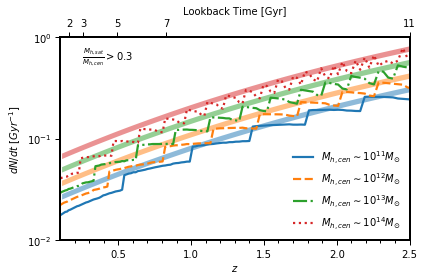

In [6]:
def FakMaIntegrand(e):
    e_bar = 9.72*(10**-3);beta=-1.995;gamma=0.263;
    return np.power(e, beta)*np.exp(np.power((e/e_bar),gamma))
def FakMa_MergerRate(M, z, e = 0.3):
    A = 0.0104; alpha = 0.133;nu=0.0993
    return A*np.power((M/10**12), alpha)*np.power(1+z, nu)*scipy.integrate.quad(FakMaIntegrand, e, 1)[0]


fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()#add time axis on top

lines = ["-", "--", "-.", ":"]
linecycler = cycle(lines)
colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "k"]
colourcycler = cycle(colours)
for j, M0 in enumerate([11, 12, 13, 14]):
    colour = next(colourcycler)
    line = next(linecycler)
    Y_dt = []
    X = []
    for i in range(len(z[:-1])):
        try:
            M0_bin_zi = np.digitize(M0, bins = AvaHaloMass[i]) -1
            Y_dt.append(Accreted_Above_Ratio_dt[i,M0_bin_zi])
            X.append(z[i])
        except:
            break
    ax.plot(X, np.array(Y_dt), line, label = r"$M_{h, cen} \sim$"+"$10^{%s}$"%M0+r"$M_{\odot}$", color = colour, linewidth = 2.2)
    ax.fill_between(z[1:], FakMa_MergerRate(10**(M0-0.2), z[1:])*(z_step/t_step), FakMa_MergerRate(10**(M0+0.2), z[1:])*(z_step/t_step), alpha = 0.5)
ax.set_yscale('log')
ax.set_ylim(0.01, 1)
ax.set_xlim(0.1, 2.5)
ax2.set_xlim(ax.get_xlim())
#Extra ticks
upper_x_tick_loc = [Cosmo.lookbackTime(2, inverse = True), Cosmo.lookbackTime(3, inverse = True), Cosmo.lookbackTime(5, inverse = True), Cosmo.lookbackTime(7, inverse = True), Cosmo.lookbackTime(11, inverse = True)]
ax2.set_xticks(upper_x_tick_loc)
ax2.set_xticklabels([2,3,5,7,11])
ax2.set_xlabel("Lookback Time [Gyr]")
ax2.minorticks_off()
ax.set_xlabel("$z$")
ax.set_ylabel("$dN/dt$ $[Gyr^{-1}]$")
ax.text(0.25, 0.6, r"$\frac{M_{h, sat}}{M_{h,cen}} > 0.3$")
ax.legend(loc = 4, frameon = False)
plt.tight_layout()
#plt.savefig("./PaperTwoPlotData/HaloMergerRate.png")
#plt.savefig("./PaperTwoPlotData/HaloMergerRate.pdf")
plt.show()

# Running below will muddy variabe names with above

In [ ]:
Pair_Frac_Halo, Accretion_History_Halo, z, AvaHaloMass, SatHaloMass = F.LoadData_Pair_Frac_Halo((1.0, False, False, True, True, 'G18'))
SatHaloBin = SatHaloMass[1] - SatHaloMass[0]
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
print(np.shape(Pair_Frac_Halo), np.shape(Accretion_History_Halo), np.shape(z), np.shape(AvaHaloMass), np.shape(SatHaloMass))

# STEEL Halo Pair Fractions

In [ ]:
f, SubPlots = plt.subplots(1, 2, figsize = (12,4))#, sharey = True, sharex = True)

MassCut_Arr = [11, 12, 13, 14]
MassRatio = np.log10(0.3)
a, b = np.shape(AvaHaloMass)
for MassCut in MassCut_Arr:
    Pair_Frac_Y = []
    for i in range(a):
        AvaPF = 0
        Count = 0
        for j in range(b):
            if MassCut +1 > AvaHaloMass[i,j] > MassCut:
                SubBin = np.digitize(AvaHaloMass[i,j] +np.log10(0.1), bins = SatHaloMass)
                #print(Pair_Frac_Halo[i,j,SubBin:])
                AvaPF += np.sum(Pair_Frac_Halo[i,j,SubBin:])*SatHaloBin*HMF_fun(AvaHaloMass[i,j], z[i])*AvaHaloMassBins[i,j]
                Count += HMF_fun(AvaHaloMass[i,j], z[i])*AvaHaloMassBins[i,j]
        if Count > 0: Pair_Frac_Y.append(AvaPF/Count)
        else: Pair_Frac_Y.append(0)
    SubPlots[0].plot(z, Pair_Frac_Y, label = MassCut)
SubPlots[0].set_xlabel("z")
SubPlots[0].set_ylabel("HaloPF")
SubPlots[0].legend()


MassCut_Arr = [11, 12, 13, 14]
MassRatio = np.log10(0.3)
a, b = np.shape(AvaHaloMass)
for MassCut in MassCut_Arr:
    Vir_Rad = []
    j_bin = np.digitize(MassCut, bins = AvaHaloMass[0])
    for i in range(a):
        AvaPF = 0
        Count = 0
        for j in range(b):
            if j==j_bin:
                Vir_Rad.append(M_to_R(np.power(10,AvaHaloMass[i,j]), z[i], 'vir')/h)
    SubPlots[1].plot(z, Vir_Rad, label = MassCut)
SubPlots[1].hlines(30, 0, 6)
SubPlots[1].set_xlabel("z")
SubPlots[1].set_ylabel("VirRad")
SubPlots[1].legend()
plt.show()

In [39]:
VDB_otp = F.Halogrowth(14.0, FullReturn = True)

In [45]:
z, M = VDB_otp[:,1], VDB_otp[:,3]+14

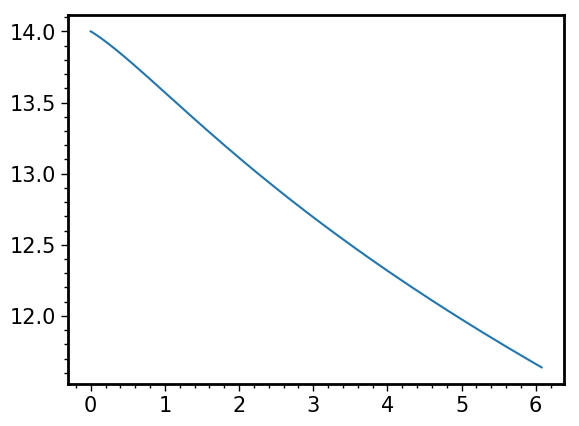

In [46]:
plt.plot(z, M)